In [0]:
import os
os.getcwd()

os.chdir('/content/drive/My Drive/RSNA')

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!ls

'GCP Credits Request Link - RSNA.txt'
 model-0.35.h5
'Pneumonia Detection Capstone (1).ipynb'
'Pneumonia Detection Capstone.ipynb'
 resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
 stage_2_detailed_class_info.csv
 stage_2_sample_submission.csv
 stage_2_train_images
 stage_2_train_labels.csv
 train_img_jpg
 X_Train_arr.npy


In [0]:
!pip install pydicom

     |████████████████████████████████| 35.3MB 89kB/s 


In [0]:
# Extracting data and exploring

In [0]:
import pydicom
import os,pylab
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import cv2
import seaborn as sns
from tqdm import tqdm


In [0]:
labels = pd.read_csv('stage_2_detailed_class_info.csv')

In [0]:
labels.drop_duplicates(inplace=True)

In [0]:
labels.head(10)

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity
6,00569f44-917d-4c86-a842-81832af98c30,No Lung Opacity / Not Normal
7,006cec2e-6ce2-4549-bffa-eadfcd1e9970,No Lung Opacity / Not Normal
8,00704310-78a8-4b38-8475-49f4573b2dbb,Lung Opacity
10,008c19e8-a820-403a-930a-bc74a4053664,No Lung Opacity / Not Normal
11,009482dc-3db5-48d4-8580-5c89c4f01334,Normal


In [0]:
# NO OF UNIQUE PATIENTS
labels['patientId'].nunique(),labels.shape

(26684, (26684, 2))

In [0]:
labels.groupby('class').count()

,patientId
class,
Lung Opacity,6012
No Lung Opacity / Not Normal,11821
Normal,8851


The labels show that their are 9555 patients with pneumonia , 11821 with other problems but not pneumonia and 8851 as normal

In [0]:
train_labels=pd.read_csv('stage_2_train_labels.csv')

In [0]:
train_labels.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [0]:
train_labels = train_labels.fillna(float(0))

In [0]:
train_labels = train_labels.fillna(int(0))
train_labels.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0.0,0.0,0.0,0.0,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,0.0,0.0,0.0,0.0,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,0.0,0.0,0.0,0.0,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,0.0,0.0,0.0,0.0,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [0]:
type(train_labels['Target'][0])

numpy.int64

In [0]:
train_labels.groupby('Target').count()

,patientId,x,y,width,height
Target,,,,,
0,20672,20672,20672,20672,20672
1,9555,9555,9555,9555,9555


Target 1 means pneumonia or Lung opacity for others it is zero

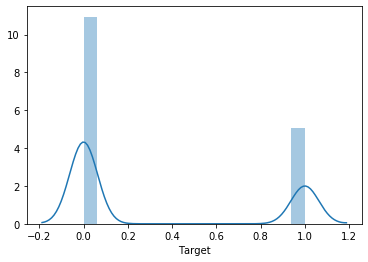

In [0]:
sns.distplot(train_labels['Target'])

In [0]:
train_data = pd.merge(left=train_labels,right=labels,on='patientId')

In [0]:
train_data.head()

,patientId,x,y,width,height,Target,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0.0,0.0,0.0,0.0,0,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,0.0,0.0,0.0,0.0,0,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,0.0,0.0,0.0,0.0,0,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,0.0,0.0,0.0,0.0,0,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity


In [0]:
train_data.describe()

,x,y,width,height,Target
count,30227.000000,30227.000000,30227.000000,30227.000000,30227.000000
mean,124.561683,115.960962,69.060575,104.084825,0.316108
std,216.326397,190.012883,106.910496,176.932152,0.464963
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,193.000000,231.000000,169.000000,188.000000,1.000000
max,835.000000,881.000000,528.000000,942.000000,1.000000


In [0]:
train_data.groupby('class').count()

,patientId,x,y,width,height,Target
class,,,,,,
Lung Opacity,9555,9555,9555,9555,9555,9555
No Lung Opacity / Not Normal,11821,11821,11821,11821,11821,11821
Normal,8851,8851,8851,8851,8851,8851


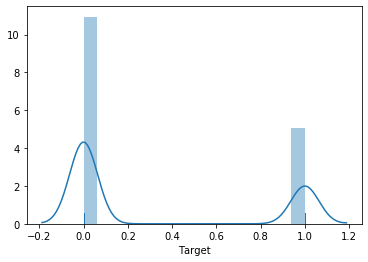

In [0]:
sns.distplot(train_data['Target'],rug=True)

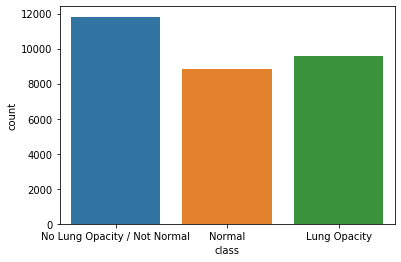

In [0]:
sns.countplot(train_data['class'])

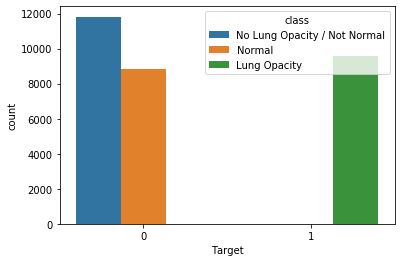

In [0]:
sns.countplot(train_data['Target'],hue=train_data['class'])

Lets look at the X-ray images one for target value 0 and one for target value 1
from train_labels.head() abve the 0 and 4th images we will see


Filename.........: ./stage_2_train_images/0004cfab-14fd-4e49-80ba-63a80b6bddd6.dcm
Patient id.......: 0004cfab-14fd-4e49-80ba-63a80b6bddd6
(1024, 1024)


(-0.5, 1023.5, 1023.5, -0.5)

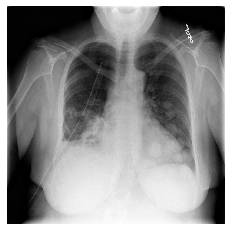

In [0]:
file = train_labels['patientId'][0]+'.dcm'
path = os.path.join('./stage_2_train_images/',file)
image = pydicom.dcmread(path)
print()
print("Filename.........:", path)
#print("class:",image.class)

print("Patient id.......:", image.PatientID)
img = image.pixel_array
print(img.shape)
pylab.imshow(img, cmap=pylab.cm.gist_gray)
pylab.axis('off')



Filename.........: ./stage_2_train_images/00436515-870c-4b36-a041-de91049b9ab4.dcm
Patient id.......: 00436515-870c-4b36-a041-de91049b9ab4


(-0.5, 1023.5, 1023.5, -0.5)

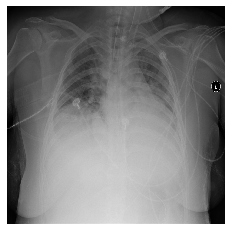

In [0]:
file = train_labels['patientId'][4]+'.dcm'
path = os.path.join('./stage_2_train_images/',file)
image = pydicom.dcmread(path)
print()
print("Filename.........:", path)


print("Patient id.......:", image.PatientID)

img = image.pixel_array
pylab.imshow(img, cmap=pylab.cm.gist_gray)
pylab.axis('off')


In [0]:
def parse_data(df):
    """
    Method to read a CSV file (Pandas dataframe) and parse the 
    data into the following nested dictionary:

      parsed = {
        
        'patientId-00': {
            'dicom': path/to/dicom/file,
            'label': either 0 or 1 for normal or pnuemonia, 
            'boxes': list of box(es)
        },
        'patientId-01': {
            'dicom': path/to/dicom/file,
            'label': either 0 or 1 for normal or pnuemonia, 
            'boxes': list of box(es)
        }, ...

      }

    """
    # --- Define lambda to extract coords in list [y, x, height, width]
    extract_box = lambda row: [row['y'], row['x'], row['height'], row['width']]

    parsed = {}
    for n, row in df.iterrows():
        # --- Initialize patient entry into parsed 
        pid = row['patientId']
        if pid not in parsed:
            parsed[pid] = {
                'dicom': './stage_2_train_images/%s.dcm' % pid,
                'label': row['Target'],
                'boxes': [],
                'class': row['class']}

        # --- Add box if opacity is present
        if parsed[pid]['label'] == 1:
            parsed[pid]['boxes'].append(extract_box(row))
        
    return parsed

In [0]:
parsed = parse_data(train_data)

In [0]:
df_parsed = pd.DataFrame(parsed)

In [0]:
df_final = df_parsed.T
df_final.head()

,dicom,label,boxes,class
0004cfab-14fd-4e49-80ba-63a80b6bddd6,./stage_2_train_images/0004cfab-14fd-4e49-80ba...,0,[],No Lung Opacity / Not Normal
00313ee0-9eaa-42f4-b0ab-c148ed3241cd,./stage_2_train_images/00313ee0-9eaa-42f4-b0ab...,0,[],No Lung Opacity / Not Normal
00322d4d-1c29-4943-afc9-b6754be640eb,./stage_2_train_images/00322d4d-1c29-4943-afc9...,0,[],No Lung Opacity / Not Normal
003d8fa0-6bf1-40ed-b54c-ac657f8495c5,./stage_2_train_images/003d8fa0-6bf1-40ed-b54c...,0,[],Normal
00436515-870c-4b36-a041-de91049b9ab4,./stage_2_train_images/00436515-870c-4b36-a041...,1,"[[152.0, 264.0, 379.0, 213.0], [152.0, 562.0, ...",Lung Opacity


In [0]:
df_final.shape

(26684, 4)

In [0]:
df_final.groupby('class').count()

,dicom,label,boxes
class,,,
Lung Opacity,6012,6012,6012
No Lung Opacity / Not Normal,11821,11821,11821
Normal,8851,8851,8851


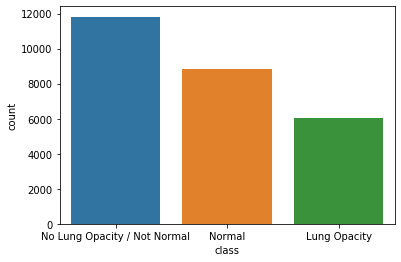

In [0]:
sns.countplot(df_final['class'])

In [0]:
if not os.path.exists('./train_img_jpg/'):
    os.mkdir('./train_img_jpg/')
    jpg_path = './train_img_jpg/'
    for i in range(len(df_final['dicom'])):
        ds = pydicom.read_file(df_final['dicom'][i])
        img = ds.pixel_array # get image array
        cv2.imwrite(jpg_path + df_final['dicom'][i].split('/')[2].replace('.dcm','.jpg'),img) # write jpg image


(-0.5, 1023.5, 1023.5, -0.5)

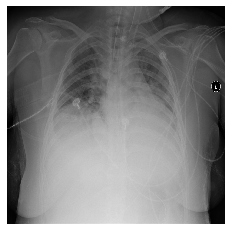

In [0]:
ds = pydicom.read_file(df_final['dicom'][4])
img = ds.pixel_array
pylab.imshow(img, cmap=pylab.cm.gist_gray)
pylab.axis('off')

In [0]:
'''
import os
path = os.listdir('./train_img1_jpg/')
file = path[4]
img = cv2.imread('./train_img1_jpg/'+df_final['dicom'][4].split('/')[2].split('.')[0]+'.jpg',0)
scale_percent = 50 # percent of original size
width = int(img.shape[1] * scale_percent / 100)
height = int(img.shape[0] * scale_percent / 100)
dim = (width, height) 
img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA) 
cv2.imshow('image',img)
cv2.waitKey(0)
v2.destroyAllWindows() 
'''

In [0]:
path = os.listdir('./train_img_jpg/')
lst = []
for i in range(len(path)):
    lst.append(path[i].split('.')[0])

In [0]:
path[:5]

['000924cf-0f8d-42bd-9158-1af53881a557.jpg',
 '000db696-cf54-4385-b10b-6b16fbb3f985.jpg',
 '000fe35a-2649-43d4-b027-e67796d412e0.jpg',
 '001031d9-f904-4a23-b3e5-2c088acd19c6.jpg',
 '0010f549-b242-4e94-87a8-57d79de215fc.jpg']

In [0]:
df_train = df_final.reindex(lst,columns=['dicom','boxes','class','label'])


In [0]:
df_train

,dicom,boxes,class,label
000924cf-0f8d-42bd-9158-1af53881a557,./stage_2_train_images/000924cf-0f8d-42bd-9158...,[],Normal,0
000db696-cf54-4385-b10b-6b16fbb3f985,./stage_2_train_images/000db696-cf54-4385-b10b...,"[[318.0, 316.0, 478.0, 170.0], [375.0, 660.0, ...",Lung Opacity,1
000fe35a-2649-43d4-b027-e67796d412e0,./stage_2_train_images/000fe35a-2649-43d4-b027...,"[[282.0, 570.0, 409.0, 269.0], [227.0, 83.0, 4...",Lung Opacity,1
001031d9-f904-4a23-b3e5-2c088acd19c6,./stage_2_train_images/001031d9-f904-4a23-b3e5...,"[[160.0, 66.0, 608.0, 373.0], [164.0, 552.0, 6...",Lung Opacity,1
0010f549-b242-4e94-87a8-57d79de215fc,./stage_2_train_images/0010f549-b242-4e94-87a8...,[],Normal,0
...,...,...,...,...
0ab261f9-4eb5-42ab-a9a5-e918904d6356,./stage_2_train_images/0ab261f9-4eb5-42ab-a9a5...,"[[352.0, 613.0, 102.0, 106.0], [644.0, 266.0, ...",Lung Opacity,1
0ab601ca-5f86-498f-89ab-73208a353e40,./stage_2_train_images/0ab601ca-5f86-498f-89ab...,"[[338.0, 132.0, 398.0, 255.0], [560.0, 644.0, ...",Lung Opacity,1
0ab731ef-0580-4a2e-9fa2-29a243b71c86,./stage_2_train_images/0ab731ef-0580-4a2e-9fa2...,[],Normal,0
0abbde89-55e8-4b25-ba9b-17a99f84bae0,./stage_2_train_images/0abbde89-55e8-4b25-ba9b...,[],No Lung Opacity / Not Normal,0


In [0]:
df_train.shape

(26684, 4)

In [16]:
y_label = np.array(df_train['label'].reset_index(drop=True))
y_class = np.array(df_train['class'].reset_index(drop=True))
y_boxes = np.array(df_train['boxes'].reset_index(drop=True))

NameError: ignored

In [0]:
y_test = np.array(y_label,dtype='int64')

In [0]:
y_test = y_test.reshape(len(y_label),1)

In [0]:
y_test.shape,y_test[0].dtype

((26684, 1), dtype('int64'))

In [0]:
def draw(data):
    """
    Method to draw single patient with bounding box(es) if present 

    """
    # --- Open DICOM file
    d = pydicom.read_file(data['dicom'])
    im = d.pixel_array

    # --- Convert from single-channel grayscale to 3-channel RGB
    im = np.stack([im] * 3, axis=2)

    # --- Add boxes with random color if present
    for box in data['boxes']:
        rgb = np.floor(np.random.rand(3) * 256).astype('int')
        im = overlay_box(im=im, box=box, rgb=rgb, stroke=6)

    pylab.imshow(im, cmap=pylab.cm.gist_gray)
    pylab.axis('off')

def overlay_box(im, box, rgb, stroke=1):
    """
    Method to overlay single box on image

    """
    # --- Convert coordinates to integers
    box = [int(b) for b in box]
    
    # --- Extract coordinates
    y1, x1, height, width = box
    y2 = y1 + height
    x2 = x1 + width

    im[y1:y1 + stroke, x1:x2] = rgb
    im[y2:y2 + stroke, x1:x2] = rgb
    im[y1:y2, x1:x1 + stroke] = rgb
    im[y1:y2, x2:x2 + stroke] = rgb

    return im

In [0]:
print(parsed[train_labels['patientId'][4]])


{'dicom': './stage_2_train_images/00436515-870c-4b36-a041-de91049b9ab4.dcm', 'label': 1, 'boxes': [[152.0, 264.0, 379.0, 213.0], [152.0, 562.0, 453.0, 256.0]], 'class': 'Lung Opacity'}


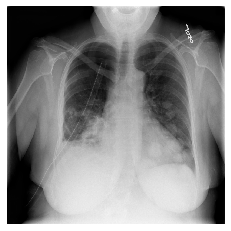

In [0]:
draw(parsed[train_data['patientId'][0]])


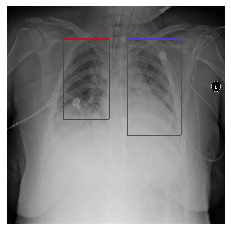

In [0]:
draw(parsed[train_data['patientId'][4]])

In [0]:
if not os.path.exists('./test_jpg/'):
    os.mkdir('./test_jpg/')
    folder_path = './stage_2_test_images/'
    jpg_path = './test_jpg/'
    path = os.listdir(folder_path)
    for idx,image in enumerate(path):
        img = pydicom.dcmread(os.path.join(folder_path,image))
        rows=[]
        img_pixel = img.pixel_array
        image = image.replace('.dcm','.jpg')
        cv2.imwrite(os.path.join(jpg_path,image),img_pixel)

In [0]:
import numpy as np
data = np.load('X_Train_arr.npy')

In [14]:
data.shape

(26683, 224, 224, 3)

In [15]:
from sklearn.model_selection import train_test_split
X_trn, X_tst, y_trn, y_tst = train_test_split(data, y_test[:26683], test_size=0.2, random_state=2)

NameError: ignored

In [0]:
X_trn.shape

(21346, 224, 224, 3)

In [0]:
path = './train_img_jpg/'
for data in os.listdir('./train_img_jpg/'):
    img_path = path + data
    print(img_path)
    break

./train_img_jpg/000924cf-0f8d-42bd-9158-1af53881a557.jpg


In [0]:
import cv2

In [4]:
img = cv2.imread('./train_img_jpg/000924cf-0f8d-42bd-9158-1af53881a557.jpg')
img.shape

(1024, 1024, 3)

# Now we have Dicom data 
# We have test images and train images converted from .dcm to .jpg


In [6]:
from keras.applications import ResNet50,resnet50,densenet
from keras.applications.resnet50 import preprocess_input
from keras.models import Sequential,Model
from keras_preprocessing import image
from keras import optimizers
from keras.layers import Dense,Input,Conv2D,MaxPooling2D,GlobalAveragePooling2D,Dropout,Flatten,AveragePooling2D
import tensorflow as tf

Using TensorFlow backend.


In [7]:
#resnet50 = ResNet50(include_top = False,pooling='avg',weights=weights)
input_image = Input(shape=(None,None, 3))
resnet50 = ResNet50(include_top=False, input_tensor=input_image)
resnet50.load_weights('resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')
for layer in resnet50.layers[:]:
    layer.trainable = False    
#make the last 9 layers trainable
for layer in resnet50.layers[len(resnet50.layers)-4:]:
    layer.trainable = True

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 1s 0us/step


In [8]:
#image_input = Input(shape=(224, 224, 3))
#model = resnet50(include_top=True, weights=wt, input_tensor=input_image)
#model.summary()
x = resnet50.output
# add fully-connected & dropout layers
x = GlobalAveragePooling2D()(x)
#x = Dense(512, activation='relu',name='fc-1')(x)
#x = Dropout(0.5)(x)
x = Dense(256, activation='relu',name='fc-2')(x)
#x = Dropout(0.5)(x)

out = Dense(1, activation='sigmoid',name='output_layer')(x)

# this is the model we will train
model = Model(inputs=resnet50.input, outputs=out)

model.summary()




Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
___________________________________________________________________________________________

In [0]:
from keras import optimizers
sgd = optimizers.SGD(lr=0.01,decay = 1e-6,momentum=0.9,nesterov=True)
adam = optimizers.Adam(lr=0.0001,decay = 1e-6)


In [0]:
# Early Callback and Check Point
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
checkpoint = ModelCheckpoint("model-{loss:.2f}.h5", monitor="loss", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="min", period=1)
stop = EarlyStopping(monitor="loss", patience=5, mode="min")
#reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1, mode="min")

In [0]:
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log, epsilon
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + epsilon())

In [0]:
def dice_coefficient(y_true, y_pred,smooth=1):
    #### Add your code here ####
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [11]:
from keras import backend as K
#model.load_weights('resnet50_weights_tf_dim_ordering_tf_kernels.h5')
#model.compile(loss=loss, optimizer=adam)
model.compile(optimizer=sgd,loss='binary_crossentropy',metrics=['accuracy'])




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
# as the images are converted to array data and saved as .npy no need to run this 
'''
import numpy as np
import glob
import cv2
X_data = []
files = glob.glob ("./train_img_jpg/*.jpg")
for i in range(len(files)-1):
    #print(myFile)
        img = cv2.imread (files[i])
        img = cv2.resize(img,(224,224), interpolation = cv2.INTER_LANCZOS4)
    #print(img)
    #cv2.imshow('image',img)
        X_data.append(img)
X_Train = np.array(X_data)
X_Train = X_Train.reshape(X_Train.shape[0],224,224,3)
np.save('X_Train_arr',X_Train)
'''

In [0]:
X_Train.shape

(26683, 224, 224, 3)

In [0]:
fit_model = model.fit(X_trn[:5000],y_trn[:5000],
                    epochs=2,batch_size=1,
                    callbacks=[checkpoint, stop],
                    verbose=1)

Epoch 1/2
5000/5000 [==============================] - 88s 18ms/step - loss: 0.5645

Epoch 00001: loss did not improve from 0.21482
Epoch 2/2
5000/5000 [==============================] - 87s 17ms/step - loss: 0.2156

Epoch 00002: loss did not improve from 0.21482


In [0]:
y_pred = model.predict(X_tst)

In [0]:
y_pred[:10],y_test[:10]

(array([[1.19268894e-04],
        [3.39746475e-06],
        [1.16229057e-06],
        [3.57627869e-07],
        [9.95397568e-05],
        [1.19209290e-07],
        [2.38418579e-07],
        [6.85453415e-06],
        [2.74181366e-06],
        [4.17232513e-07]], dtype=float32), array([[0],
        [1],
        [1],
        [1],
        [0],
        [1],
        [1],
        [0],
        [0],
        [0]]))

In [0]:
model.evaluate(X_tst,y_tst)

5337/5337 [==============================] - 13s 2ms/step


[1.4230917498527986, 0.7704703015447534]

In [0]:
# Retinanet for Object Detection

In [0]:
def getpath(pid):
    """ Given an ID, return the path of the jpeg relative to the data dir """
    return os.path.join('../train_img_jpg'+"/"+pids[pid]+".jpg")

In [3]:
pids[0]

NameError: ignored

In [43]:
boxdict['c1f7889a-9ea9-4acb-b64c-b737c929599a']

[(570, 393, 831, 738), (233, 424, 434, 780)]

In [51]:
getpath(0)

'../train_img_jpg/0004cfab-14fd-4e49-80ba-63a80b6bddd6.jpg'

In [0]:
def anno(idx):
    """ Return a list of bounding box annotations given a list of IDs """
    annolist = []
    for p_id in idx:
        boxes = boxdict[pids[p_id]]
        if boxes:
            for box in boxes:
                annolist.append([getpath(p_id), box[0], box[1],
                                 box[2], box[3], 'pneumonia'])
        else:
            annolist.append([getpath(p_id), '', '', '', '', ''])
    return annolist


In [6]:
# creating anootation files for image and labels
from collections import defaultdict
import json
import glob
import os
import pandas as pd
from sklearn.model_selection import StratifiedKFold
df = pd.read_csv('stage_2_train_labels.csv', keep_default_na=False)
sz = 1000
boxdict = defaultdict(list)
pids = []
targets = []
for index, row in df.iterrows():
    pid = row['patientId']
    x = row['x']
    y = row['y']
    width = row['width']
    height = row['height']
    target = int(row['Target'])
    conversion = sz/1000
    if x != '':
        x1 = int(float(x))
        y1 = int(float(y))
        x2 = x1+int(float(width))
        if x2 > sz:
            x2 = sz
        y2 = y1+int(float(height))
        if y2 > sz:
            y2 = sz

        x1 = int(x1*conversion)
        y1 = int(y1*conversion)
        x2 = int(x2*conversion)
        y2 = int(y2*conversion)
        target = 'pneumonia'

        boxdict[pid].append((x1, y1, x2, y2))

    if pid not in pids:
        pids.append(pid)
        targets.append(target)

stratSplit = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
folds = list(stratSplit.split(pids, targets))

# I trained with a few folds, this one yielded the best models
(train_idx, val_idx) = folds[5]

train_annotations = anno(train_idx)
val_annotations = anno(val_idx)
print(f"Training: {len(train_idx)}, validation: {len(val_idx)}")
pd_train_annotations = pd.DataFrame.from_records(train_annotations)
pd_val_annotations = pd.DataFrame.from_records(val_annotations)

pd_train_annotations.to_csv('train1.csv', index=False, header=False)
pd_val_annotations.to_csv('val1.csv', index=False, header=False)
with open('classes.csv', 'w') as class_file:
    class_file.write('pneumonia,0')

FileNotFoundError: ignored

In [0]:
#Training: 25349, validation: 1335

In [0]:
!git clone https://github.com/fizyr/keras-retinanet.git

Cloning into 'keras-retinanet'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 5563 (delta 0), reused 3 (delta 0), pack-reused 5557
Receiving objects: 100% (5563/5563), 13.34 MiB | 7.16 MiB/s, done.
Resolving deltas: 100% (3726/3726), done.


In [138]:
%cd keras-retinanet/
!pip install .

[Errno 2] No such file or directory: 'keras-retinanet/'
/content/drive/My Drive/RSNA/Mask_RCNN
Processing /content/drive/My Drive/RSNA/Mask_RCNN
  Created wheel for mask-rcnn: filename=mask_rcnn-2.1-cp36-none-any.whl size=56923 sha256=30f0af3e14324ab6c35bd0f09c4ab975d62952573849e36bf935555f6bb7f260
  Stored in directory: /tmp/pip-ephem-wheel-cache-ycn0xenm/wheels/30/29/7e/338127b051c499f53a9753b4491356423c4ce79cdf2c94325a
Successfully built mask-rcnn
  Found existing installation: mask-rcnn 2.1
    Uninstalling mask-rcnn-2.1:
      Successfully uninstalled mask-rcnn-2.1


In [141]:
%cd ../keras-retinanet/

/content/drive/My Drive/RSNA/keras-retinanet


In [142]:
!python setup.py build_ext --inplace

running build_ext
skipping 'keras_retinanet/utils/compute_overlap.c' Cython extension (up-to-date)
copying build/lib.linux-x86_64-3.6/keras_retinanet/utils/compute_overlap.cpython-36m-x86_64-linux-gnu.so -> keras_retinanet/utils


In [0]:
import os
import shutil
import zipfile
import urllib
import xml.etree.ElementTree as ET
import numpy as np
import csv
import pandas
from google.colab import drive
from google.colab import files
PRETRAINED_MODEL = './snapshots/_pretrained_model.h5'

#### OPTION 1: DOWNLOAD INITIAL PRETRAINED MODEL FROM FIZYR ####
#URL_MODEL = 'https://github.com/fizyr/keras-retinanet/releases/resnet50_coco_best_v2.1.0.h5'
URL_MODEL = 'https://github.com/fizyr/keras-retinanet/releases/download/0.5.1/resnet50_coco_best_v2.1.0.h5'
urllib.request.urlretrieve(URL_MODEL, PRETRAINED_MODEL)

#### OPTION 2: DOWNLOAD CUSTOM PRETRAINED MODEL FROM GOOGLE DRIVE. CHANGE DRIVE_MODEL VALUE. USE THIS TO CONTINUE PREVIOUS TRAINING EPOCHS ####
#drive.mount('/content/gdrive')
#DRIVE_MODEL = '/content/gdrive/My Drive/Colab Notebooks/objdet_tensorflow_colab/resnet50_csv_10.h5'
#shutil.copy(DRIVE_MODEL, PRETRAINED_MODEL)


print('Downloaded pretrained model to ' + PRETRAINED_MODEL)

Downloaded pretrained model to ./snapshots/_pretrained_model.h5


In [0]:
PRETRAINED_MODEL = './snapshots/_pretrained_model.h5'

In [0]:
!chmod 700 keras_retinanet/bin/train.py


In [1]:
pwd

'/content'

In [147]:
!pip install keras==2.3.0

     |████████████████████████████████| 378kB 2.8MB/s 
  Found existing installation: Keras 2.2.5
    Uninstalling Keras-2.2.5:
      Successfully uninstalled Keras-2.2.5


In [0]:
!chmod 700 keras_retinanet/bin/debug.py

In [0]:
!keras_retinanet/bin/debug.py csv train.csv classes.csv

Using TensorFlow backend.


In [0]:
!keras_retinanet/bin/train.py --freeze-backbone --random-transform --weights {PRETRAINED_MODEL} --batch-size 16 --steps 500 --epochs 5 csv train.csv classes.csv

Using TensorFlow backend.
Creating model, this may take a second...
Instructions for updating:
If using Keras pass *_constraint arguments to layers.

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1316: UserWarning: Skipping loading of weights for layer classification_submodel due to mismatch in shape ((3, 3, 256, 9) vs (720, 256, 3, 3)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1316: UserWarning: Skipping loading of weights for layer classification_submodel due to mismatch in shape ((9,) vs (720,)).
  weight_values[i].shape))
2020-02-26 04:00:19.666032: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-02-26 04:00:19.679413: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-02-26 04:00:19.679967: I tensorflow/co

In [0]:
model_path = os.path.join(
  'snapshots',
  sorted(os.listdir('snapshots'), reverse=True)[1]
)

In [0]:
model_path

'snapshots/resnet50_csv_10.h5'

In [0]:

from keras_retinanet.models import load_model,convert_model

In [0]:
model = load_model(model_path, backbone_name='resnet50')
#model = convert_model(model)

In [0]:
!keras_retinanet/bin/convert_model.py snapshots/resnet50_csv_10.h5 snapshots/resnet50_csv_10_inference.h5

Using TensorFlow backend.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.

2020-02-26 10:29:43.028153: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-02-26 10:29:43.030907: E tensorflow/stream_executor/cuda/cuda_driver.cc:318] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2020-02-26 10:29:43.030978: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: 8cd5a89e0301
2020-02-26 10:29:43.030997: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: 8cd5a89e0301
2020-02-26 10:29:43.031075: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 418.67.0
2020-02-26 10:29:43.031116: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 418.67.0
2020-02-26 10:29:43.031134: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc

In [0]:
!chmod 700 keras_retinanet/bin/convert_model.py

In [0]:
from keras_retinanet import losses
from keras.optimizers import Adam

In [0]:
adam = Adam(lr=1e-5,clipnorm=0.001)

In [0]:
model.compile(
    loss={
        #'regression'    : keras_retinanet.losses.smooth_l1(),
        'regression'    : losses.smooth_l1(),
        #'classification': keras_retinanet.losses.focal()
        'classification': losses.focal(),
        
    },
    optimizer=adam
)

In [0]:
!keras_retinanet/bin/evaluate.py csv val.csv classes.csv snapshots/resnet50_csv_10.h5 --convert-model

Using TensorFlow backend.
Loading model, this may take a second...
Instructions for updating:
If using Keras pass *_constraint arguments to layers.

2020-02-26 10:39:20.694444: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-02-26 10:39:20.697955: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-02-26 10:39:20.698750: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: Tesla K80 major: 3 minor: 7 memoryClockRate(GHz): 0.8235
pciBusID: 0000:00:04.0
2020-02-26 10:39:20.698995: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2020-02-26 10:39:20.701344: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so

In [0]:
!chmod 700 keras_retinanet/bin/evaluate.py

In [0]:
model = convert_model(model)

tracking <tf.Variable 'Variable_10:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_11:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_12:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_13:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_14:0' shape=(9, 4) dtype=float32> anchors


In [0]:
import pandas as
labels_to_names = pd.read_csv(
  'classes.csv',
  header=None
).T.loc[0].to_dict()

In [0]:
labels_to_names

{0: 'pneumonia'}

In [0]:
THRES_SCORE = 0.6

In [0]:
# show images inline
%matplotlib inline

# automatically reload modules when they have changed
%reload_ext autoreload
%autoreload 2

# import keras
import keras

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

# set tf backend to allow memory to grow, instead of claiming everything
import tensorflow as tf

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    return tf.Session(config=config)

# use this environment flag to change which GPU to use
#os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# set the modified tf session as backend in keras
keras.backend.tensorflow_backend.set_session(get_session())

In [0]:
def predict(image):
  image = preprocess_image(image.copy())
  image, scale = resize_image(image)

  boxes, scores,labels = model.predict_on_batch(
    np.expand_dims(image, axis=0)
  )

  boxes /= scale

  return boxes, scores, labels

In [0]:

def run_detection_image(filepath):
    image = read_image_bgr(filepath)
#     print(image.shape)
#     print(image)

    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    # preprocess image for network
    #image = preprocess_image(image)
    #image, scale = resize_image(image)

    # process image
    start = time.time()
    boxes, scores,labels = model.predict(np.expand_dims(image, axis=0))
    print("processing time: ", time.time() - start)

    # correct for image scale
    #boxes /= scale

    # visualize detections
    for box, score, label in zip(boxes[0], scores[0], labels[0]):
        # scores are sorted so we can break
        if score < 0.3:
            break

        color = label_color(label)

        b = box.astype(int)
        draw_box(draw, b, color=color)

        caption = "{} {:.3f}".format(labels_to_names[label], score)
        draw_caption(draw, b, caption)

    plt.figure(figsize=(15, 15))
    plt.axis('off')
    plt.imshow(draw)
    plt.show()

In [0]:
img_lst = os.listdir('../train_img_jpg/')
img_lst[:10]

['000924cf-0f8d-42bd-9158-1af53881a557.jpg',
 '000db696-cf54-4385-b10b-6b16fbb3f985.jpg',
 '000fe35a-2649-43d4-b027-e67796d412e0.jpg',
 '001031d9-f904-4a23-b3e5-2c088acd19c6.jpg',
 '0010f549-b242-4e94-87a8-57d79de215fc.jpg',
 '001916b8-3d30-4935-a5d1-8eaddb1646cd.jpg',
 '0022073f-cec8-42ec-ab5f-bc2314649235.jpg',
 '0022995a-45eb-4cfa-9a59-cd15f5196c64.jpg',
 '0025d2de-bd78-4d36-9f72-e15a5e22ca82.jpg',
 '00293de0-a530-41dc-9621-0b3def01d06d.jpg']

In [0]:
img_infer = '../train_img_jpg/00436515-870c-4b36-a041-de91049b9ab4.jpg'

In [0]:
import pandas
labels_to_names = pandas.read_csv('classes.csv',header=None).T.loc[0].to_dict()

processing time:  0.36458635330200195


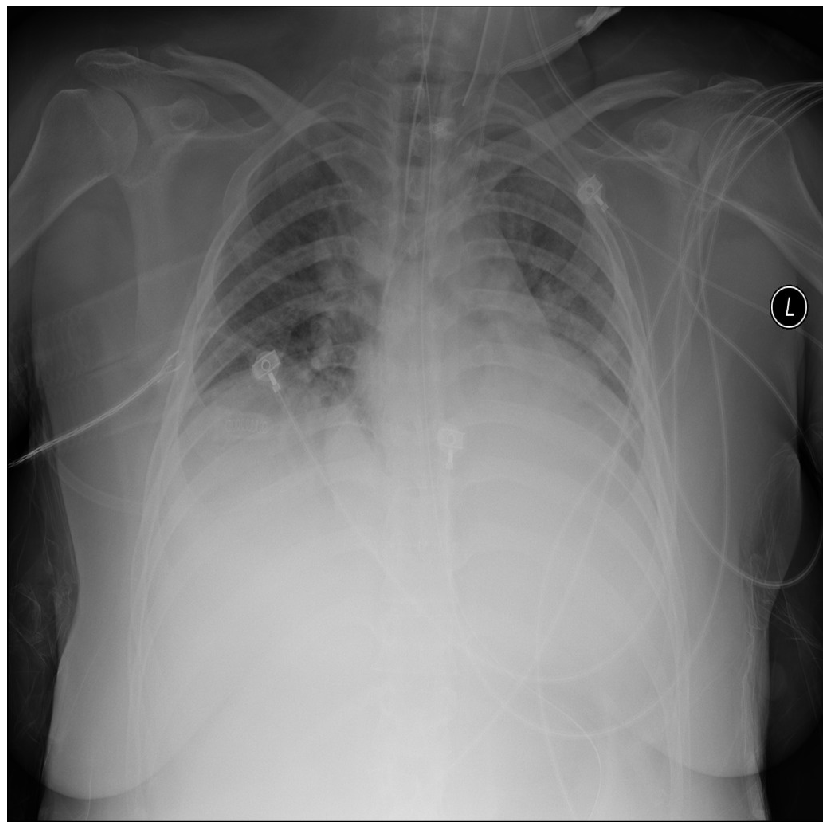

In [0]:
run_detection_image(img_infer)

In [0]:
import csv
annotations_file = 'val.csv'
cwd = os.getcwd()

image_names = []

with open (os.path.join(cwd, annotations_file)) as csvfile:
    readCSV = csv.reader(csvfile, delimiter='\n')
    for row in readCSV:
        vals = row[0].split(',')
        this_filepath = vals[0]
        image_names.append(this_filepath)
        
## remove duplicates by taking a set
image_names = list(set(image_names))
print(len(image_names))

1335


In [0]:
def get_gt_annotations(filepath):
    gt_ann = []
    with open (os.path.join(cwd, annotations_file)) as csvfile:
        readCSV = csv.reader(csvfile, delimiter='\n')
        for row in readCSV:
            vals = row[0].split(',')
            this_filepath = vals[0]
            
            if this_filepath == filepath:
                record = []
                record.append((vals[1]))
                record.append((vals[2]))
                record.append((vals[3]))
                record.append((vals[4]))
                record.append(vals[5])
                
                gt_ann.append(record)
    return gt_ann

In [0]:
def bb_intersection_over_union(boxA, boxB):
	# determine the (x, y)-coordinates of the intersection rectangle
	xA = max(int(boxA[0]), int(boxB[0]))
	yA = max(int(boxA[1]), int(boxB[1]))
	xB = min(int(boxA[2]), int(boxB[2]))
	yB = min(int(boxA[3]), int(boxB[3]))
 
	# compute the area of intersection rectangle
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
 
	# compute the area of both the prediction and ground-truth
	# rectangles
	boxAArea = (int(boxA[2]) - int(boxA[0]) + 1) * (int(boxA[3]) - int(boxA[1]) + 1)
	boxBArea = (int(boxB[2]) - int(boxB[0]) + 1) * (int(boxB[3]) - int(boxB[1]) + 1)
 
	# compute the intersection over union by taking the intersection
	# area and dividing it by the sum of prediction + ground-truth
	# areas - the interesection area
	iou = interArea / float(boxAArea + boxBArea - interArea)
 
	# return the intersection over union value
	return iou

In [0]:
def highest_iou(predicted_box, gt_ann):  
    highest_iou = 0
    best_match = []
    for each_gt in gt_ann:
        this_iou = bb_intersection_over_union(predicted_box[:-1], each_gt[:-1])
#         print(" For this box is: ", this_iou)
        if this_iou > highest_iou:
            highest_iou = this_iou
            best_match = each_gt
            
    return highest_iou, best_match

In [0]:
def accuracy(gt_ann, predicted_ann):
    true_positive = []
    class_mismatch = []
    false_positive = []
    false_negative = []
    
    predicted_ann_copy = predicted_ann.copy()
    gt_ann_copy = gt_ann.copy()
    
    for each_pred in predicted_ann_copy:
        # 1. Calculate the highest_iou with any gt_box
        best_iou, best_gt_match = highest_iou(each_pred, gt_ann_copy)
#         print("Best IOU is: ", each_pred, best_gt_match, best_iou)
        
        ## If this box has a match
        if best_iou >= acceptable_box_overlap:
            ## if class label matches
            if best_gt_match[-1] == each_pred[-1]:
                ## This is a true positive
                true_positive.append(each_pred)
                ## remove this from predicted ann and gt
#                 print("Predicted Ann before:", predicted_ann)
                predicted_ann.remove(each_pred)
#                 print("Predicted Ann after:", predicted_ann)
                if best_gt_match in gt_ann:
                    gt_ann.remove(best_gt_match)
            elif best_gt_match[-1] != each_pred[-1]:
                ## this is a class mismatch
                class_mismatch.append(each_pred)
                ## remove this box
                predicted_ann.remove(each_pred)
                if best_gt_match in gt_ann:
                    gt_ann.remove(best_gt_match)
        
    ## If IOU is less than 0.5, leave as is

    ## Any predicted box is now false positive
    for remain_pred in predicted_ann:
        false_positive.append(remain_pred)

    ## Any remaining gt box is false negative
    for remain_gt in gt_ann:
        if remain_gt[-1] in ['pneumonia']:
            false_negative.append(remain_gt)

    return true_positive, class_mismatch, false_positive, false_negative

In [0]:
score_threshold_retinanet = 0.4
acceptable_box_overlap = 0.3

In [0]:
def run_detection_image2(filepath):
    image = read_image_bgr(filepath)

    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)

    # process image
    start = time.time()
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
    print("processing time: ", time.time() - start)

    # correct for image scale
    boxes /= scale
    
    gt_ann = get_gt_annotations(filepath)
    num_gt_ann = len(gt_ann)
    
    predicted_ann = []

    # visualize detections
    for box, score, label in zip(boxes[0], scores[0], labels[0]):
        # scores are sorted so we can break
        if score < score_threshold_retinanet:
            break
        record = []
        record.append((box[0]))
        record.append((box[1]))
        record.append((box[2]))
        record.append((box[3]))
        record.append(labels_to_names[label])
        print("Record is: ", record)
        predicted_ann.append(record)
    
    
#     print("predicted ann are: ", predicted_ann)
    ## Calculate boxes
    true_positive, class_mismatch, false_positive, false_negative = accuracy(gt_ann, predicted_ann)
    print(len(true_positive), len(class_mismatch), len(false_positive), len(false_negative))
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    ## Draw theses on the image
    ## Draw true positive in green
    if len(true_positive) > 0:
        for each_true in true_positive:
            cv2.rectangle(draw,(each_true[0],each_true[1]),(each_true[2],each_true[3]),(0,255,0),3) #green
            cv2.putText(draw, each_true[-1], (each_true[0]-2, each_true[1]-2),font, 0.5,
                        (0,0,0),1,cv2.LINE_AA) # text in black
        
    ## Draw class mismatch in light blue   
    if len(class_mismatch) > 0:
        for each_mismatch in class_mismatch:
            cv2.rectangle(draw,(each_mismatch[0],each_mismatch[1]),(each_mismatch[2],each_mismatch[3]),(255,255,0),3) #green
            cv2.putText(draw, each_mismatch[-1], (each_mismatch[0]-2, each_mismatch[1]-2),font, 0.5,
                        (0,0,0),1,cv2.LINE_AA) # text in black
        
    
     ## Draw false positive  in blue 
    if len(false_positive) > 0:
        for each_fp in false_positive:
            cv2.rectangle(draw,(each_fp[0],each_fp[1]),(each_fp[2],each_fp[3]),(255,0,0),3) #green
            cv2.putText(draw, each_fp[-1], (each_fp[0]-2, each_fp[1]-2),font, 0.5,
                        (0,0,0),1,cv2.LINE_AA) # text in black
    
    
     ## Draw false negative in red 
    if len(false_negative) > 0:
        for each_fn in false_negative:
            cv2.rectangle(draw,(each_fn[0],each_fn[1]),(each_fn[2],each_fn[3]),(0,0,255),3) #green
            cv2.putText(draw, each_fn[-1], (each_fn[0]-2, each_fn[1]-2),font, 0.5,
                        (0,0,0),1,cv2.LINE_AA) # text in black
            
            
    ## Add key to the image
    cv2.putText(draw, "True Positive", (1200, 20),font, 0.8, (0,255,0),1,cv2.LINE_AA) 
    cv2.putText(draw, "Class Mismatch", (1200, 50),font, 0.8, (255,255,0),1,cv2.LINE_AA)
    cv2.putText(draw, "False Positive", (1200, 80),font, 0.8, (255,0,0),1,cv2.LINE_AA)
    cv2.putText(draw, "False Negtaive", (1200, 110),font, 0.8, (0,0,2550),1,cv2.LINE_AA)
    
    ### Save this image
    
    file, ext = os.path.splitext(filepath)
    image_name = file.split('/')[-1] + ext
    output_path = os.path.join('examples/results_test/', image_name)
    
    draw_conv = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)
    cv2.imwrite(output_path, draw_conv)
    
    return len(true_positive), len(class_mismatch), len(false_positive), len(false_negative), num_gt_ann

In [0]:
run_detection_image2(img_infer)

processing time:  0.2726125717163086
0 0 0 0


(0, 0, 0, 0, 0)

In [0]:
filepath = image_names[:10]

In [0]:
total_true_positive = 0
total_class_mismatch = 0
total_false_positive = 0
total_false_negative = 0
total_gt = 0

In [0]:
for files in filepath:
    num_tp, num_cm , num_fp, num_fn, num_gt = run_detection_image2(files)
    print("Ground Truth: ", num_gt)
    total_true_positive += num_tp
    total_class_mismatch += num_cm
    total_false_positive += num_fp
    total_false_negative += num_fn
    total_gt += num_gt

processing time:  0.26022815704345703
0 0 0 0
Ground Truth:  1
processing time:  0.21860408782958984
0 0 0 0
Ground Truth:  1
processing time:  0.19325566291809082
0 0 0 0
Ground Truth:  1
processing time:  0.19317102432250977
0 0 0 0
Ground Truth:  1
processing time:  0.19733715057373047
0 0 0 0
Ground Truth:  1
processing time:  0.19273591041564941
0 0 0 0
Ground Truth:  1
processing time:  0.2032015323638916
0 0 0 0
Ground Truth:  1
processing time:  0.19457292556762695
0 0 0 0
Ground Truth:  2
processing time:  0.1992959976196289
0 0 0 0
Ground Truth:  1
processing time:  0.19259142875671387
0 0 0 0
Ground Truth:  1


In [0]:
# Mask RCNN Model

In [14]:
!pip3 install -q pydicom 
!pip3 install -q tqdm 
!pip3 install -q imgaug 

     |████████████████████████████████| 35.3MB 88kB/s 


In [0]:
import os 
import sys

import random
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
import pydicom
from imgaug import augmenters as iaa
from tqdm import tqdm
import pandas as pd 
import glob 

In [17]:
% cd ..

/content/drive/My Drive/RSNA


In [19]:
!git clone https://github.com/matterport/Mask_RCNN.git

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 111.84 MiB | 11.36 MiB/s, done.
Resolving deltas: 100% (570/570), done.
Checking out files: 100% (76/76), done.


In [21]:
%cd Mask_RCNN/
!python setup.py -q install

/content/drive/My Drive/RSNA/Mask_RCNN
zip_safe flag not set; analyzing archive contents...


In [0]:
home_path ='/content/drive/My Drive/RSNA'

In [23]:
import sys
sys.path.append(os.path.join(home_path, 'Mask_RCNN'))  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

Using TensorFlow backend.


In [0]:
train_dicom_dir = os.path.join(home_path, 'stage_2_train_images')

In [0]:
def get_dicom_fps(dicom_dir):
    dicom_fps = glob.glob(dicom_dir+'/'+'*.dcm')
    return list(set(dicom_fps))

def parse_dataset(dicom_dir, anns): 
    image_fps = get_dicom_fps(dicom_dir)
    image_annotations = {fp: [] for fp in image_fps}
    for index, row in anns.iterrows(): 
        fp = os.path.join(dicom_dir, row['patientId']+'.dcm')
        image_annotations[fp].append(row)
    return image_fps, image_annotations 

In [26]:
# The following parameters have been selected to reduce running time for demonstration purposes 
# These are not optimal 

class DetectorConfig(Config):
    """Configuration for training pneumonia detection on the RSNA pneumonia dataset.
    Overrides values in the base Config class.
    """
    
    # Give the configuration a recognizable name  
    NAME = 'pneumonia'
    
    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8 
    
    BACKBONE = 'resnet50'
    
    NUM_CLASSES = 2  # background + 1 pneumonia classes
    
    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 64
    IMAGE_MAX_DIM = 64
    
    RPN_ANCHOR_SCALES = (32, 64)
    
    TRAIN_ROIS_PER_IMAGE = 16
    
    MAX_GT_INSTANCES = 3
    
    DETECTION_MAX_INSTANCES = 3
    DETECTION_MIN_CONFIDENCE = 0.9
    DETECTION_NMS_THRESHOLD = 0.1
    
    RPN_TRAIN_ANCHORS_PER_IMAGE = 16
    STEPS_PER_EPOCH = 100 
    TOP_DOWN_PYRAMID_SIZE = 32
    STEPS_PER_EPOCH = 100
    
    
config = DetectorConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        3
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.1
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  64
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  64
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [64 64  3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     

In [0]:
class DetectorDataset(utils.Dataset):
    """Dataset class for training pneumonia detection on the RSNA pneumonia dataset.
    """

    def __init__(self, image_fps, image_annotations, orig_height, orig_width):
        super().__init__(self)
        
        # Add classes
        self.add_class('pneumonia', 1, 'Lung Opacity')
   
        # add images 
        for i, fp in enumerate(image_fps):
            annotations = image_annotations[fp]
            self.add_image('pneumonia', image_id=i, path=fp, 
                           annotations=annotations, orig_height=orig_height, orig_width=orig_width)
            
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

    def load_image(self, image_id):
        info = self.image_info[image_id]
        fp = info['path']
        ds = pydicom.read_file(fp)
        image = ds.pixel_array
        # If grayscale. Convert to RGB for consistency.
        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1)
        return image

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        annotations = info['annotations']
        count = len(annotations)
        if count == 0:
            mask = np.zeros((info['orig_height'], info['orig_width'], 1), dtype=np.uint8)
            class_ids = np.zeros((1,), dtype=np.int32)
        else:
            mask = np.zeros((info['orig_height'], info['orig_width'], count), dtype=np.uint8)
            class_ids = np.zeros((count,), dtype=np.int32)
            for i, a in enumerate(annotations):
                if a['Target'] == 1:
                    x = int(a['x'])
                    y = int(a['y'])
                    w = int(a['width'])
                    h = int(a['height'])
                    mask_instance = mask[:, :, i].copy()
                    cv2.rectangle(mask_instance, (x, y), (x+w, y+h), 255, -1)
                    mask[:, :, i] = mask_instance
                    class_ids[i] = 1
        return mask.astype(np.bool), class_ids.astype(np.int32)

In [28]:
# training dataset
anns = pd.read_csv(os.path.join(home_path, 'stage_2_train_labels.csv'))
anns.head(6)

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1


In [0]:
image_fps, image_annotations = parse_dataset(train_dicom_dir, anns=anns)

In [31]:
#Split the data into training and validation datasets
import random
image_fps_list = list(image_fps[:10000]) 
sorted(image_fps_list)
random.seed(42)
random.shuffle(image_fps_list)

validation_split = 0.1
split_index = int((1 - validation_split) * len(image_fps_list))

image_fps_train = image_fps_list[:split_index]
image_fps_val = image_fps_list[split_index:]

print(len(image_fps_train), len(image_fps_val))

9000 1000


In [0]:
# prepare the training dataset
ORIG_SIZE = 1024
dataset_train = DetectorDataset(image_fps_train, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_train.prepare()

In [35]:
# Show annotation(s) for a DICOM image 
test_fp = random.choice(image_fps_train)
image_annotations[test_fp]

[patientId    35c98046-1334-4b50-8232-41fcc65d150e
 x                                             618
 y                                             406
 width                                         152
 height                                        158
 Target                                          1
 Name: 3052, dtype: object]

In [0]:
# prepare the validation dataset
dataset_val = DetectorDataset(image_fps_val, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_val.prepare()

(1024, 1024, 3)
/content/drive/My Drive/RSNA/stage_2_train_images/f7bd2b79-ca7e-4787-9d78-7041d7aa7498.dcm
[1 1]


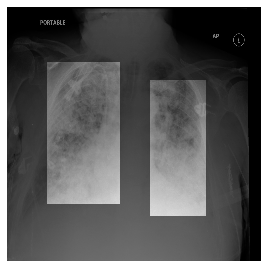

In [71]:
# Load and display random samples and their bounding boxes
# Suggestion: Run this a few times to see different examples. 

image_id = random.choice(dataset_train.image_ids)
image_fp = dataset_train.image_reference(image_id)
image = dataset_train.load_image(image_id)
mask, class_ids = dataset_train.load_mask(image_id)

print(image.shape)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(image[:, :, 0], cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 1)
masked = np.zeros(image.shape[:2])
for i in range(mask.shape[2]):
    masked += image[:, :, 0] * mask[:, :, i]
plt.imshow(masked, cmap='gray',alpha=.5)
plt.axis('off')

print(image_fp)
print(class_ids)

In [0]:
MODEL_DIR = os.path.join(home_path, 'logs')
model = modellib.MaskRCNN(mode='training', config=config, model_dir=MODEL_DIR)

In [0]:
# Image augmentation 
from imgaug import augmenters as iaa
augmentation = iaa.SomeOf((0, 1), [
    iaa.Fliplr(0.5),
    iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-25, 25),
        shear=(-8, 8)
    ),
    iaa.Multiply((0.9, 1.1))
])

In [42]:
# Train Mask-RCNN Model 
NUM_EPOCHS = 1
import warnings 
warnings.filterwarnings("ignore")
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=NUM_EPOCHS, 
            layers='all',
            augmentation=augmentation)


Starting at epoch 0. LR=0.001

Checkpoint Path: /content/drive/My Drive/RSNA/logs/pneumonia20200227T1815/mask_rcnn_pneumonia_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2

In [48]:
# select trained model 
dir_names = next(os.walk(model.model_dir))[1]
key = config.NAME.lower()
dir_names = filter(lambda f: f.startswith(key), dir_names)
dir_names = sorted(dir_names)

if not dir_names:
    import errno
    raise FileNotFoundError(
        errno.ENOENT,
        "Could not find model directory under {}".format(self.model_dir))
    
fps = []
# Pick last directory
for d in dir_names: 
    dir_name = os.path.join(model.model_dir, d)
    # Find the last checkpoint
    checkpoints = next(os.walk(dir_name))[2]
    checkpoints = filter(lambda f: f.startswith("mask_rcnn"), checkpoints)
    checkpoints = sorted(checkpoints)
    if not checkpoints:
        print('No weight files in {}'.format(dir_name))
    else: 
      
      checkpoint = os.path.join(dir_name, checkpoints[-1])
      fps.append(checkpoint)

model_path = sorted(fps)[-1]
print('Found model {}'.format(model_path))

Found model /content/drive/My Drive/RSNA/logs/pneumonia20200227T1815/mask_rcnn_pneumonia_0001.h5


In [76]:
class InferenceConfig(DetectorConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /content/drive/My Drive/RSNA/logs/pneumonia20200227T1815/mask_rcnn_pneumonia_0001.h5
Re-starting from epoch 1


In [0]:
# set color for class
def get_colors_for_class_ids(class_ids):
    colors = []
    for class_id in class_ids:
        if class_id == 1:
            colors.append((.941, .204, .204))
    return colors


*** No instances to display *** 


*** No instances to display *** 


*** No instances to display *** 



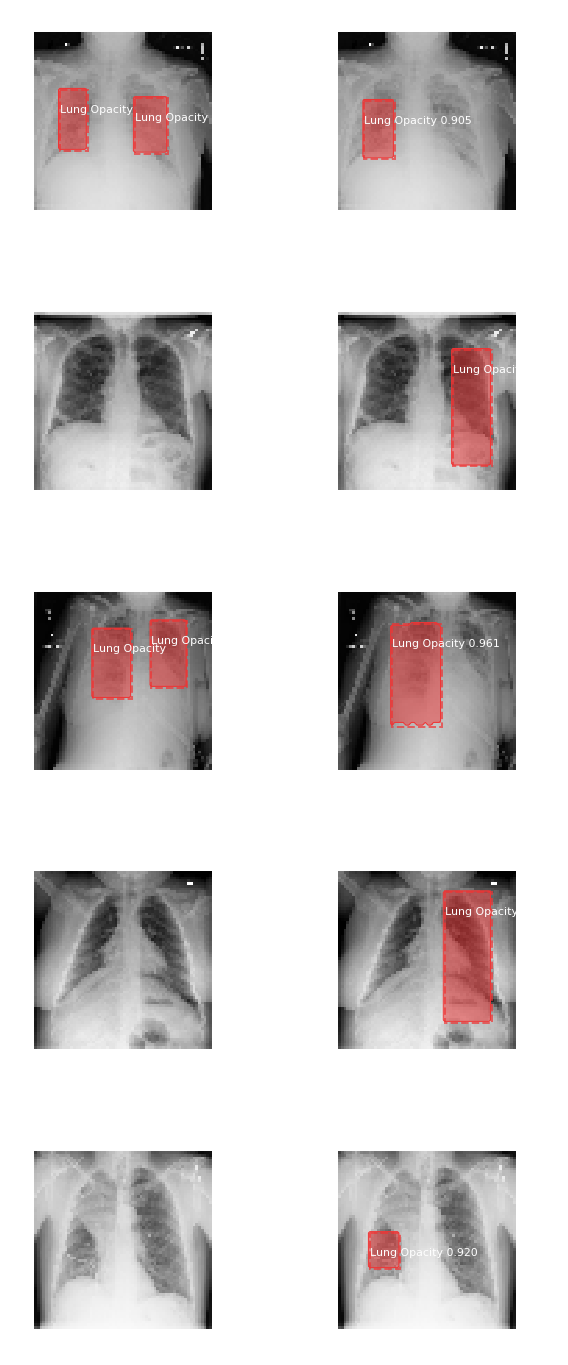

In [121]:
# Show few example of ground truth vs. predictions on the validation dataset 
dataset = dataset_val
fig = plt.figure(figsize=(10, 30))
gt_bb = []
pr_bb = []
for i in range(5):

    image_id = random.choice(dataset.image_ids)
    
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config, 
                               image_id, use_mini_mask=False)
    gt_bb.append(gt_bbox)    
    plt.subplot(6, 2, 2*i + 1)
    visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                                dataset.class_names,
                                colors=get_colors_for_class_ids(gt_class_id), ax=fig.axes[-1])
    
    plt.subplot(6, 2, 2*i + 2)
    results = model.detect([original_image]) #, verbose=1)
    pr_bb.append(results[0])
    r = results[0]
    
    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                                dataset.class_names, r['scores'], 
                                colors=get_colors_for_class_ids(r['class_ids']), ax=fig.axes[-1])

In [0]:
b = pr_bb[0]['rois'][0]

In [136]:
a = gt_bb[0][1]
a

array([20,  9, 42, 19], dtype=int32)

In [0]:
def bb_intersection_over_union(boxA, boxB):
	# determine the (x, y)-coordinates of the intersection rectangle
	xA = max(int(boxA[0]), int(boxB[0]))
	yA = max(int(boxA[1]), int(boxB[1]))
	xB = min(int(boxA[2]), int(boxB[2]))
	yB = min(int(boxA[3]), int(boxB[3]))
 
	# compute the area of intersection rectangle
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
 
	# compute the area of both the prediction and ground-truth
	# rectangles
	boxAArea = (int(boxA[2]) - int(boxA[0]) + 1) * (int(boxA[3]) - int(boxA[1]) + 1)
	boxBArea = (int(boxB[2]) - int(boxB[0]) + 1) * (int(boxB[3]) - int(boxB[1]) + 1)
 
	# compute the intersection over union by taking the intersection
	# area and dividing it by the sum of prediction + ground-truth
	# areas - the interesection area
	iou = interArea / float(boxAArea + boxBArea - interArea)
 
	# return the intersection over union value
	return iou

In [137]:
bb_intersection_over_union(a, b)

0.6785714285714286